In [21]:
## Imports and such
import sys
sys.path.append('../')

from ibmfl_cli_automator.run import get_config, Runner, changedict

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os

fusion_algos = [a for a in os.listdir("../../testtest/remote") if a.find(".") == -1]

In [4]:
fusion_algos

['shuf_iter_avg', 'fed_avg', 'coord_med', 'krum', 'iter_avg']

In [23]:
results = {}
n_trials = 1

In [24]:
import pandas as pd
import numpy as np

def av(item):
    arr = np.array(item)
    avg = arr.mean(axis=0).flatten()
    return avg

def process_trial_results(results):
    """
    averages the two numbers per round/metric, then takes the avg and std
    of each round/metric across the trials
    """
    dfs = []
    for i in range(n_trials):
        rounds = results[i]['metadata'][0]['round_no']
        dfs.append(pd.DataFrame(
            {key: av(item) for key, item in results[i].items()
            if key is not "metadata"},
            index=rounds
        ))

    return {
        "avg": pd.DataFrame(
            np.array(dfs).mean(axis=0), index=dfs[0].index, columns=dfs[0].columns
        ),
        "std": pd.DataFrame(
            np.array(dfs).std(axis=0), index=dfs[0].index, columns=dfs[0].columns
        )
    }


def process_better_trial_results(dfs):
    """
    averages the two numbers per round/metric, then takes the avg and std
    of each round/metric across the trials
    """

    return {
        "avg": pd.DataFrame(
            np.array(dfs).mean(axis=0), index=dfs[0].index, columns=dfs[0].columns
        ),
        "std": pd.DataFrame(
            np.array(dfs).std(axis=0), index=dfs[0].index, columns=dfs[0].columns
        )
    }

import json


def postproc_fn(staging):
    folder = f"{staging}/latest/"
    parties = {}
    for obj in os.listdir(folder):
        if obj.endswith(".json"):
            party = int(obj[:-5].split("party")[1])
            dfs = []
            with open(f"{folder}/{obj}", 'r') as openfile:
                json_object = json.load(openfile)
                for round in json_object:
                    round_no = round['round_no']
                    dfs.append(pd.DataFrame(round).iloc[:, 1:3])
                    dfs[round_no] = dfs[round_no].append(
                        pd.Series(
                            dfs[round_no].iloc[0] - dfs[0].iloc[0],
                            name="te"
                        )
                    )
                    dfs[round_no] = pd.Series(
                        dfs[round_no].iloc[:, 0].tolist() + \
                        dfs[round_no].iloc[:, 0].tolist(),
                        index=("pre_train:" + dfs[round_no].index).tolist() + \
                        ("post_train:" + dfs[round_no].index).tolist(),
                        name=round_no
                    )
                parties[party] = pd.DataFrame(dfs)

    round_results = np.array(list(parties.values())).mean(axis=0)

    round_avgs = pd.DataFrame(
        round_results,
        index=parties[0].index,
        columns=parties[0].columns
    )
    round_avgs.axes[0].name = "round"

    return round_avgs

In [11]:
server_in, port_in, username_in = "192.168.1.167 22 trevormaxjs".split(' ')

import paramiko
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
print()
client.connect("trevormax-precision5750") # , key_filename="/home/trevormaxjs/.ssh/precision2")

In [ ]:
192.168.1.167 22 trevormaxjs

In [19]:
server_in, port_in, username_in = "192.168.1.167 22 trevormaxjs".split(' ')

import paramiko
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
print()
client.connect(server_in, port_in, username_in) # , key_filename="/home/trevormaxjs/.ssh/precision2")

In [28]:
client.exec_command("1+1")

(<paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0xe6f872b0 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>,
 <paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0xe6f872b0 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>,
 <paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0xe6f872b0 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>)

In [26]:
for fusion in fusion_algos:
    display("testing fusion algorithm:")
    display(fusion)
    agg, party, glob = get_config(f"../../testtest/remote/{fusion}/")
    print(glob)
    print(agg)
    break


    results[fusion] = []
    machines = glob['machines']
    experiments = glob['experiments']
    agg['hyperparams']['global']['termination_accuracy'] = 0.999
    party['data']['info']['npz_file'] = '${staging_dir}/testtest/balanced_data/data_party${id}.npz'    
#     agg['hyperparams']['global']['rounds'] = 5
#     experiments[0]['n_parties'] = 5

    for i in range(n_trials):
        runner = Runner()
        experiments[0]
        runner.run_experiment(
            experiments[0],
            machines,
            agg,
            party,
            ui_mode="cli"
        )

        runner.call_postproc_fn()
        results[fusion].append(postproc_fn(f"../../"))

    results[fusion] = process_better_trial_results(results[fusion])
    results[fusion]['avg'].to_csv(f"../../testtest/remote/{fusion}/results_avg_2.csv")
    results[fusion]['std'].to_csv(f"../../testtest/remote/{fusion}/results_std_2.csv")
    display(results[fusion]['avg'])

'testing fusion algorithm:'

'shuf_iter_avg'

{'experiments': [{'agg_machine': 'local0', 'local_ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl', 'local_staging_dir': '/home/trevormaxjs/Documents/Engineering/Research', 'n_parties': 20, 'n_rounds': 20, 'n_trials': 1, 'party_machines': ['remote0', 'remote1', 'remote2', 'remote3', 'remote4', 'remote5', 'remote6', 'remote7', 'remote8', 'remote9', 'remote10', 'local1', 'local2', 'local3', 'local4', 'local5', 'local6', 'local7', 'local8', 'local9'], 'postproc_fn': 'gen_reward_vs_time_plots', 'postproc_x_key': 'post_train:ts', 'postproc_y_keys': ['post_train:eval:loss', 'post_train:eval:acc'], 'shuffle_party_machines': False}], 'isLocalRun': True, 'machines': {'default': {'ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl', 'staging_dir': '/home/trevormaxjs/Documents/Engineering/Research', 'venv_dir': '/home/trevormaxjs/Documents/Engineering/Research/venv', 'venv_uses_conda': False}, 'local0': {'ip_address': '127.0.0.1', 'port_number': 5000, 'ssh_use

In [15]:
for fusion in fusion_algos:
    results[fusion]['avg'].to_csv(f"../../testtest/remote/{fusion}/results_avg_balanced.csv")
    results[fusion]['std'].to_csv(f"../../testtest/remote/{fusion}/results_std_balanced.csv")

In [16]:
results['iter_avg']['avg'].columns

Index(['pre_train:ts', 'pre_train:eval:loss', 'pre_train:eval:acc',
       'pre_train:eval:f1 micro', 'pre_train:eval:precision micro',
       'pre_train:eval:recall micro', 'pre_train:eval:f1 macro',
       'pre_train:eval:precision macro', 'pre_train:eval:recall macro',
       'pre_train:eval:f1 weighted', 'pre_train:eval:precision weighted',
       'pre_train:eval:recall weighted', 'pre_train:te', 'post_train:ts',
       'post_train:eval:loss', 'post_train:eval:acc',
       'post_train:eval:f1 micro', 'post_train:eval:precision micro',
       'post_train:eval:recall micro', 'post_train:eval:f1 macro',
       'post_train:eval:precision macro', 'post_train:eval:recall macro',
       'post_train:eval:f1 weighted', 'post_train:eval:precision weighted',
       'post_train:eval:recall weighted', 'post_train:te'],
      dtype='object')

### GET FED AVG WORKING!!

In [17]:
for fusion in fusion_algos:
    results[fusion] = {}
    results[fusion]['avg'] = pd.read_csv(f"../../testtest/agg_tests/{fusion}/results_avg_2.csv", index_col=0)
    results[fusion]['std'] = pd.read_csv(f"../../testtest/agg_tests/{fusion}/results_std_2.csv", index_col=0)
    results[fusion]['avg']['train_time'] = results[fusion]['avg']['post_train:ts'] - results[fusion]['avg']['pre_train:ts'][0]
    results[fusion]['std']['train_time'] = results[fusion]['std']['post_train:ts'] - results[fusion]['std']['pre_train:ts'][0]
results

{'shuf_iter_avg': {'avg':        pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
  round                                                          
  0      1.681532e+09                  NaN                 NaN   
  1      1.681532e+09             0.896568            0.796714   
  2      1.681532e+09             0.480729            0.864071   
  3      1.681532e+09             0.374625            0.890129   
  4      1.681532e+09             0.333881            0.903114   
  5      1.681532e+09             0.311414            0.910957   
  6      1.681532e+09             0.296409            0.916600   
  7      1.681532e+09             0.283966            0.921886   
  8      1.681532e+09             0.273700            0.926700   
  9      1.681532e+09             0.265558            0.931043   
  10     1.681532e+09             0.258954            0.933386   
  11     1.681532e+09             0.253712            0.934214   
  12     1.681532e+09             0.246925          

In [18]:
import matplotlib.pyplot as plt

In [19]:
def plot_results(dict, round, metric):
    plt.figure()
    plt.title(f"{metric} per fusion algorithm at round {round}")
    for i, fusion in enumerate(dict.keys()):
        if dict[fusion]['avg'].shape[0] > 1 or round == 1:
            if round == -1:
                label = f"round {dict[fusion]['avg'].index[-1]}"
            else:
                label = ""
            plt.errorbar(
                [i],
                [dict[fusion]['avg'].iloc[round-1][metric]],
                [dict[fusion]['std'].iloc[round-1][metric]],
                marker='s', mfc='red', label=label
            )
    plt.xticks(np.arange(6), dict.keys())
    plt.ylabel(metric)
    if round == -1:
        plt.legend()
    plt.show()

    
def plot_results2(dict, metric):
    """
    """
    plt.figure()
    plt.title(f"{metric} per fusion algorithm vs training time")
    for i, fusion in enumerate(dict.keys()):
        if dict[fusion]['avg'].shape[0] > 1 or round == 1:
            plt.errorbar(
                dict[fusion]['avg']['train_time'],
                dict[fusion]['avg'][metric],
                dict[fusion]['std'][metric],
#                 marker='s', mfc='red',
                label=fusion
            )
#     plt.xticks(np.arange(6), dict.keys())
    plt.ylabel(metric)
    plt.xlabel("training time")
    plt.legend()
    plt.show()


def earlystop_results(results, metric, cutoff):
    resultscopy = {}
    for i, fusion in enumerate(results.keys()):
        resultscopy[fusion] = {}
        resultscopy[fusion]['avg'] = results[fusion]['avg'].loc[
            results[fusion]['avg'][metric] <= cutoff].copy()
        resultscopy[fusion]['std'] = results[fusion]['std'].loc[
            resultscopy[fusion]['avg'].index].copy()
    return resultscopy

In [20]:
earlystop_results(results, "post_train:eval:acc", 0.9)

{'shuf_iter_avg': {'avg':        pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
  round                                                          
  1      1.681532e+09             0.896568            0.796714   
  2      1.681532e+09             0.480729            0.864071   
  3      1.681532e+09             0.374625            0.890129   
  
         pre_train:eval:f1 micro  pre_train:eval:precision micro  \
  round                                                            
  1                     0.620857                        0.969929   
  2                     0.855143                        0.926500   
  3                     0.889786                        0.919714   
  
         pre_train:eval:recall micro  pre_train:eval:f1 macro  \
  round                                                         
  1                         0.456929                 0.558071   
  2                         0.795500                 0.845714   
  3                         0.861714    

flf1 weighted - 

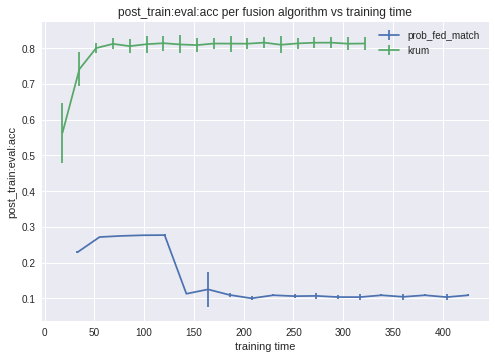

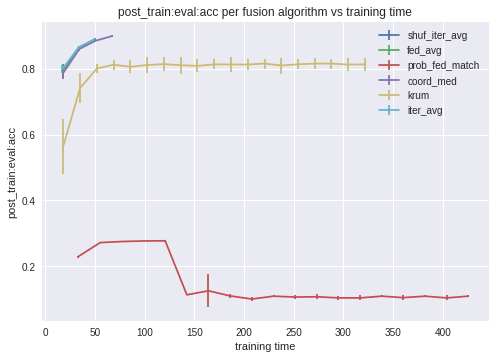

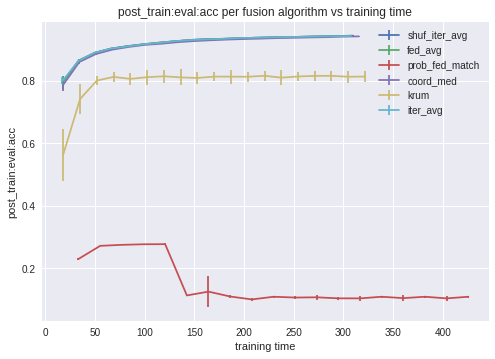

In [21]:
plot_results2(earlystop_results(results, "post_train:eval:acc", 0.85), "post_train:eval:acc")

plot_results2(earlystop_results(results, "post_train:eval:acc", 0.9), "post_train:eval:acc")

plot_results2(earlystop_results(results, "post_train:eval:acc", 0.95), "post_train:eval:acc")

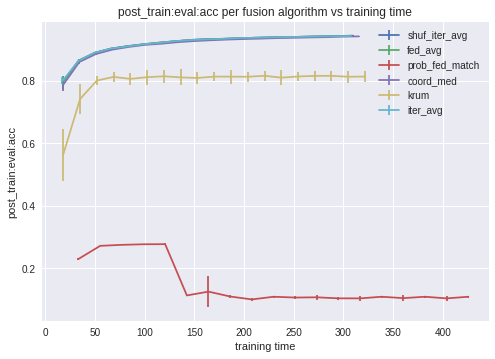

In [22]:
# plot_results2(results, "train_time")
plot_results2(results, "post_train:eval:acc")


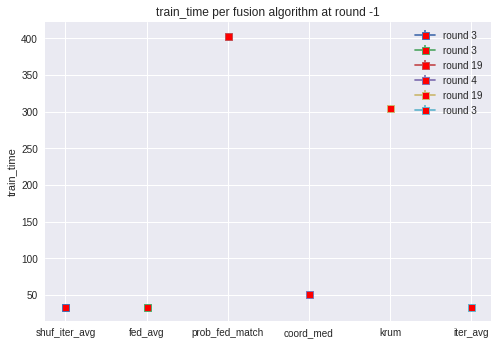

In [23]:
plot_results(
    earlystop_results(results, "post_train:eval:acc", 0.9),
    -1,
    "train_time"
)

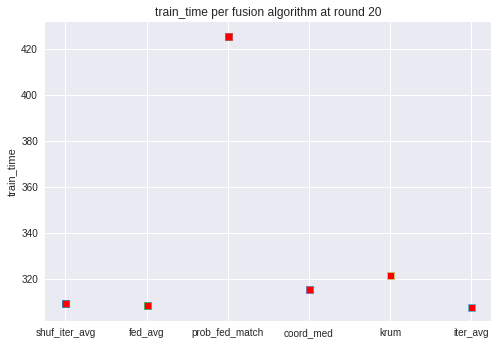

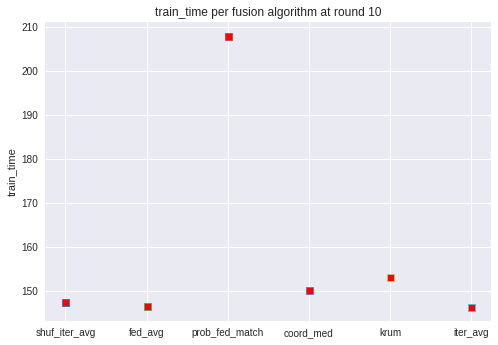

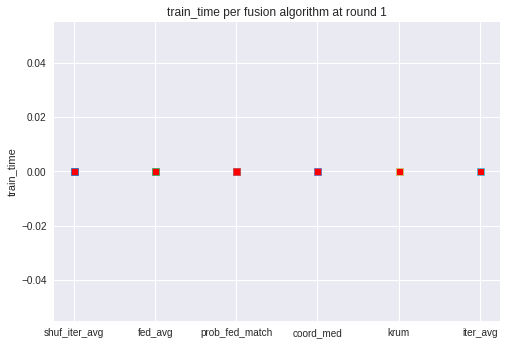

In [24]:
plot_results(results, 20, "train_time")

plot_results(results, 10, "train_time")

plot_results(results, 1, "train_time")

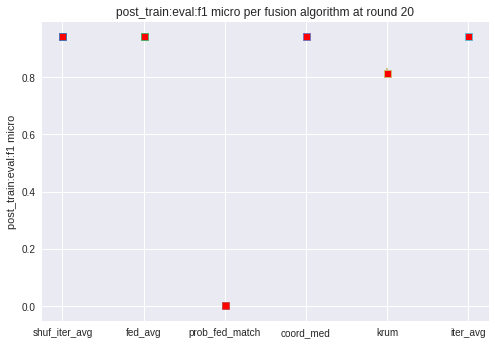

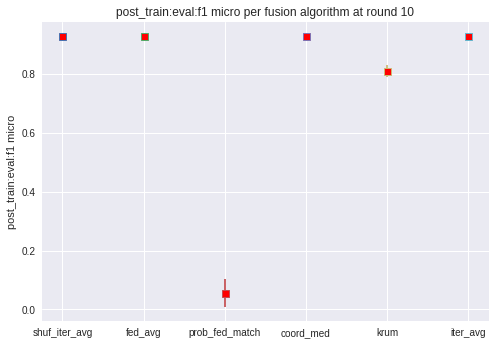

/home/trevormaxjs/miniconda3/envs/fed/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


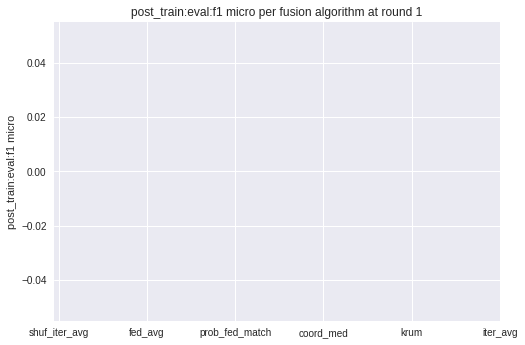

In [25]:
plot_results(results, 20, "post_train:eval:f1 micro")

plot_results(results, 10, "post_train:eval:f1 micro")

plot_results(results, 1, "post_train:eval:f1 micro")

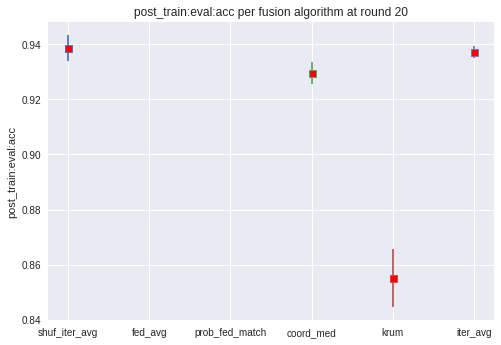

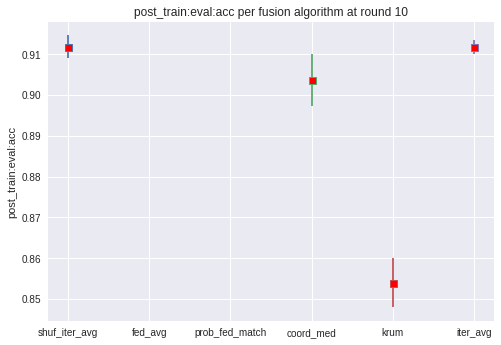

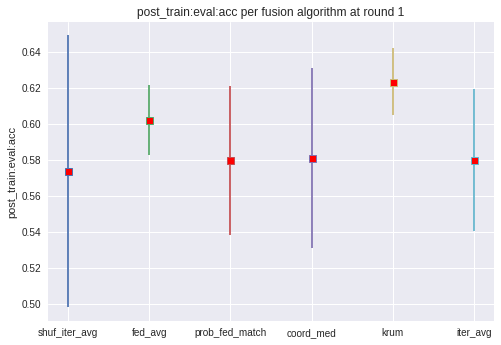

In [15]:
plot_results(results, 20, "post_train:eval:acc")

plot_results(results, 10, "post_train:eval:acc")

plot_results(results, 1, "post_train:eval:acc")

round number vs metric, plot all 6 curves

Usually add rounds but few epochs per round, start with 3 rounds. Find optimal number of rounds and use that as a baseline for further tests.

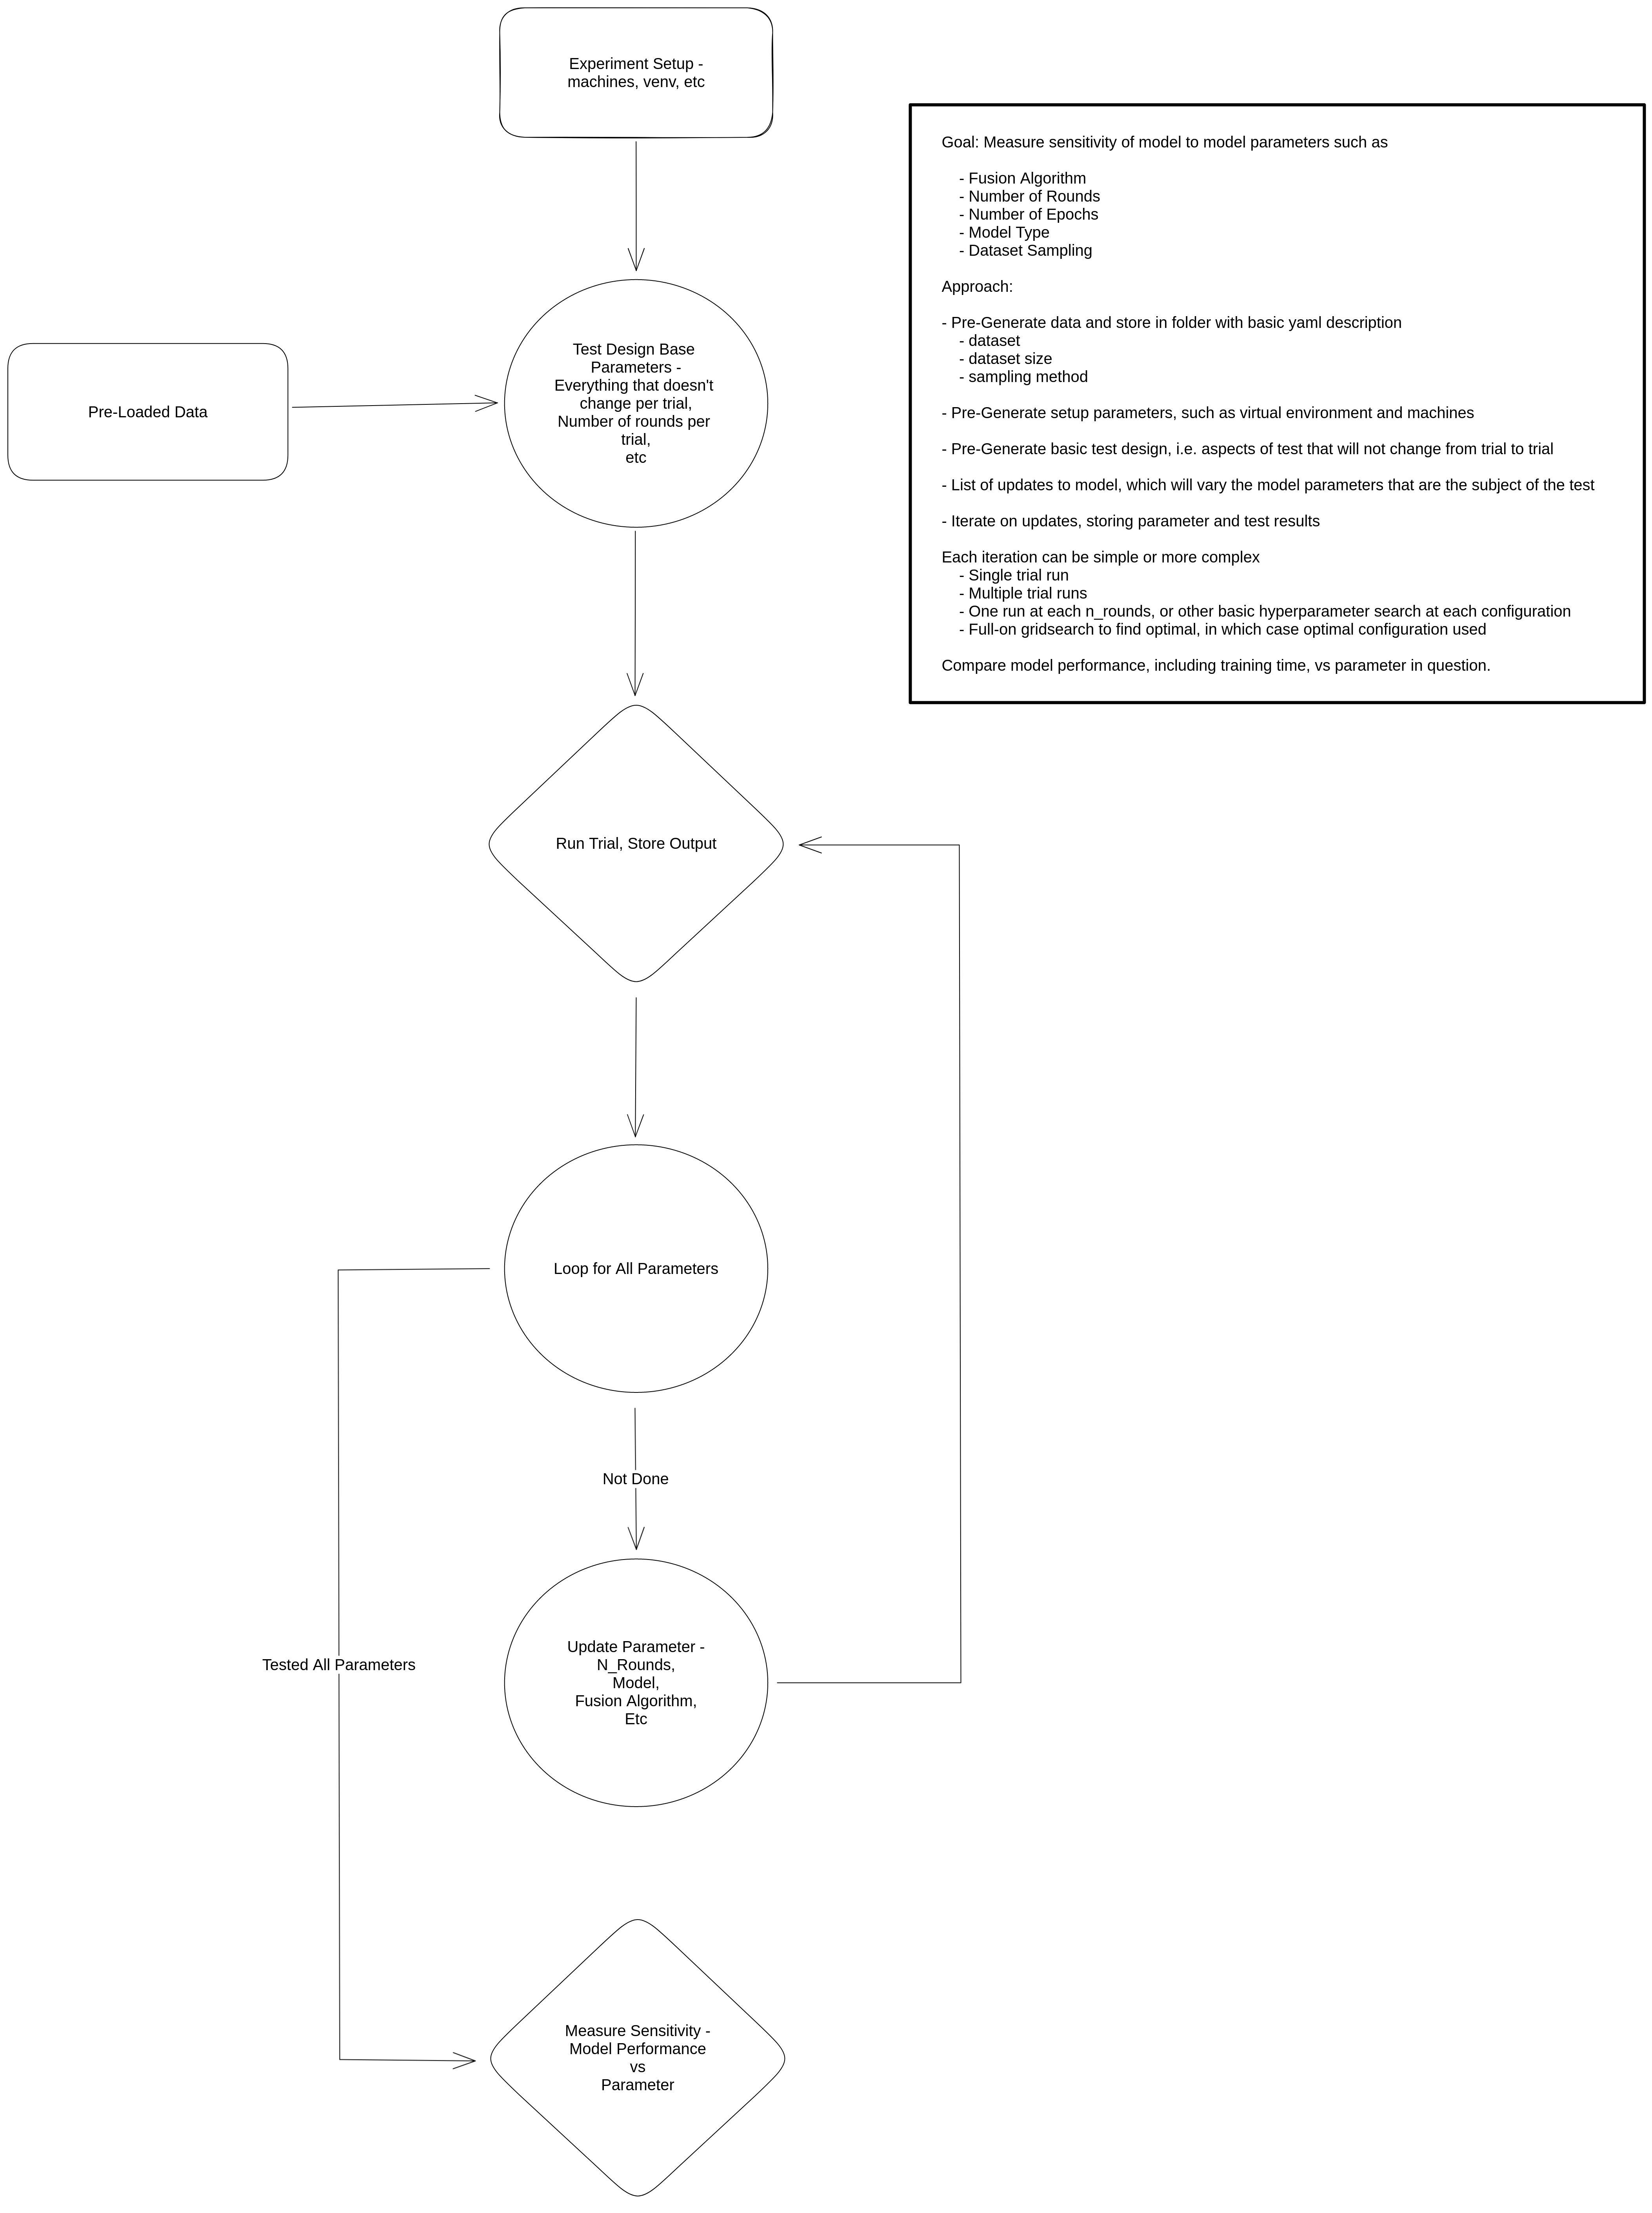